# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchsummary import summary
import random

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.
   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

In [8]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

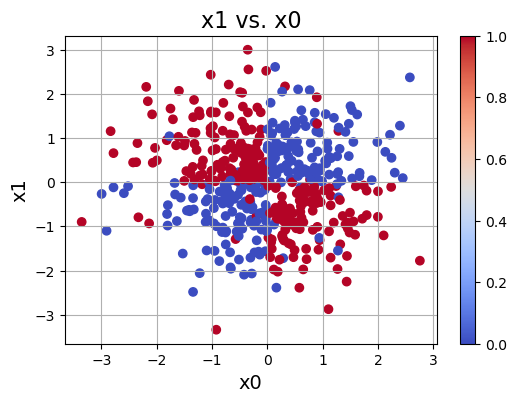

In [9]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

In [11]:
seed = 1337

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
class NeuralNet(nn.Module):
    """
    Simple feedataorward neural network with configurable input size.
    """

    def __init__(self, input_size=2):
        super(NeuralNet, self).__init__()
        self.create_model(input_size)
        self.lrs = []

    def create_model(self, input_size=2):
        self.model = nn.Sequential(
            nn.Linear(input_size, 10),
            # activation function
            nn.ReLU(),
            # hidden layer
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            # output layer
            nn.Linear(10, 1),
        )

    def forward(self, x):
        return self.model(x)

    @staticmethod
    def make_loader(X, y, batch_size=32, shuffle=True):
        """Creates a DataLoader for the given features and labels. Converts inputs to numpy and tensors.
        The dataloader:
            splits data into batches of size batch_size
            shuffles data if shuffle=True
            allows iteration over batches in a for loop
        """
        X_np = (
            X
            if isinstance(X, np.ndarray)
            else (X.to_numpy() if isinstance(X, pd.DataFrame) else np.asarray(X))
        )
        y_np = (
            y
            if isinstance(y, np.ndarray)
            else (y.to_numpy() if isinstance(y, pd.Series) else np.asarray(y))
        )
        tensor_x = torch.tensor(X_np, dtype=torch.float32)
        tensor_y = torch.tensor(y_np, dtype=torch.long)
        dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )
        return loader

    def get_lr(self, step, total_steps, warmup_steps, base_lr, min_lr):
        """Calculate learning rate at a given step with linear warmup and cosine decay.
        Manually adjusts the learning rate for each training step.
        During the first few steps ( warmup_steps ), it linerally increases from 0 to base_lr. Helps avoid instability at start of training.
        After warmup, it decays the LR using cos curve from base_lr to min_lr.
        Helps prevent overfitting by reducing the learning rate as training progresses. Allows large initial updates and fine-tuning later.
        """
        if step < warmup_steps:
            return base_lr * (step / warmup_steps)
        else:
            progress = (step - warmup_steps) / max(1, (total_steps - warmup_steps))
            return min_lr + 0.5 * (base_lr - min_lr) * (
                1 + math.cos(math.pi * progress)
            )

    def scaledata(self, x_train=None, x_test=None):
        """Scale the training and test data using StandardScaler"""
        self.scaler = StandardScaler()
        X_train_s = self.scaler.fit_transform(x_train)
        X_test_s = self.scaler.transform(x_test)
        return X_train_s, X_test_s

    def train_model(
        self,
        train_loader,
        n_epochs=200,
        base_lr=0.001,
        min_lr=1e-5,
        warmup_steps=20,
        device="cpu",
    ):
        """Train on full training set (no validation). Returns trained model and lists of train losses/accuracies."""
        # loss function, combines sigmoid and log loss
        criterion = nn.BCEWithLogitsLoss()
        # an optimizer is something that updates the model weights based on computed gradients.
        optimizer = optim.Adam(self.model.parameters(), lr=base_lr)
        train_losses, train_accs = [], []
        total_steps = n_epochs * len(train_loader)
        warmup_steps = int(0.05 * total_steps) if warmup_steps is None else warmup_steps
        global_step = 0
        self.model.to(device)
        for _ in range(n_epochs):
            self.model.train()
            running_loss = 0.0
            correct, total = 0, 0
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                lr = self.get_lr(
                    global_step, total_steps, warmup_steps, base_lr, min_lr
                )
                self.lrs.append(lr)

                for g in optimizer.param_groups:
                    g["lr"] = lr
                optimizer.zero_grad()
                outputs = self.model(inputs).squeeze()
                labels_smoothed = labels.float() * 0.9 + 0.05
                loss = criterion(outputs, labels_smoothed)
                # loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) >= 0.5).long()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                global_step += 1
            train_loss = running_loss / len(train_loader.dataset)
            train_acc = correct / total if total > 0 else 0
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            # print(f'Epoch {epoch+1}/{n_epochs} LR={lr:.6f} TrainLoss={train_loss:.4f} TrainAcc={train_acc:.2f}')
        return self.model, train_losses, train_accs

    def evaluate_model(self, test_loader, device="cpu"):
        self.model.to(device)
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs).squeeze()
                predicted = (torch.sigmoid(outputs) >= 0.5).long()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total if total > 0 else 0
        print(f"Test Accuracy: {accuracy:.2f}")
        return accuracy

    def plot_training_curves(self, train_losses, train_accuracies):
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label="Training Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_learning_rate_schedule(
        self,
        n_epochs=200,
        base_lr=0.001,
        min_lr=1e-5,
        warmup_steps=20,
        train_loader=None,
    ):
        """Plot the learning rate curve (warmup + cosine decay)."""
        plt.figure(figsize=(6, 4))
        plt.plot(self.lrs)
        plt.xlabel("Training Step")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Schedule (Warmup + Cosine Decay)")
        plt.grid(True)
        plt.show()

In [13]:
# Use entire train set 
X_train_df, y_train = train[['x0','x1']], train['y']
X_test_df,  y_test  = test[['x0','x1']],  test['y']

# Convert to numpy arrays
x_train = X_train_df.to_numpy()
x_test  = X_test_df.to_numpy()

# Create a neural network instance for scaling
model_for_scaling = NeuralNet(input_size=2)
# Scale data
X_train_s, X_test_s = model_for_scaling.scaledata(x_train, x_test)

test_loader = NeuralNet.make_loader(
    X_test_s, y_test.to_numpy(), batch_size=32, shuffle=False
)

In [14]:
# Hyperparameter grid
grid_search = {
    "base_lr": [0.003, 0.001, 0.0003],
    "dropout": [0.05, 0.1, 0.2],
    "batch_size": [16, 32, 64],
}

best_accuracy = 0
best_parameters = None
results = []

for learning_rate in grid_search["base_lr"]:
    for dropout in grid_search["dropout"]:
        for batch_size in grid_search["batch_size"]:
            print(
                f"\n learning rate={learning_rate}, Dropout={dropout}, BS={batch_size}"
            )
            model = NeuralNet(input_size=2)

            # Set dropout rate
            for layer in model.model:
                if isinstance(layer, nn.Dropout):
                    layer.p = dropout

            # Use the same scaled data
            train_loader = NeuralNet.make_loader(
                X_train_s, y_train.to_numpy(), batch_size=batch_size, shuffle=True
            )

            # Train model
            trained_model, losses, accs = model.train_model(
                train_loader,
                n_epochs=400,
                base_lr=learning_rate,
                min_lr=1e-6,
            )

            # Evaluate
            accuracy = model.evaluate_model(test_loader)
            results.append((learning_rate, dropout, batch_size, accuracy))

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_parameters = (learning_rate, dropout, batch_size)

            print(f"→ Test acc {accuracy:.4f} | Best so far {best_accuracy:.4f}")

            # Early exit if we hit target
            if accuracy >= 0.92:
                break
        if best_accuracy >= 0.92:
            break
    if best_accuracy >= 0.92:
        break

print(
    f"\n Best parameters: LR={best_parameters[0]}, Dropout={best_parameters[1]}, BS={best_parameters[2]} with accuracy {best_accuracy:.4f}"
)


 learning rate=0.003, Dropout=0.05, BS=16
Test Accuracy: 0.92
→ Test acc 0.9180 | Best so far 0.9180

 learning rate=0.003, Dropout=0.05, BS=32
Test Accuracy: 0.91
→ Test acc 0.9120 | Best so far 0.9180

 learning rate=0.003, Dropout=0.05, BS=64
Test Accuracy: 0.91
→ Test acc 0.9140 | Best so far 0.9180

 learning rate=0.003, Dropout=0.1, BS=16
Test Accuracy: 0.92
→ Test acc 0.9220 | Best so far 0.9220

 Best parameters: LR=0.003, Dropout=0.1, BS=16 with accuracy 0.9220


1. How can you make sure the results are reproduable?
We use seeding. A seed is a starting number that tells the computer’s random number generator where to begin. Computers don’t have “true” randomness, they use pseudo-random numbers. If we give the number generator the same seed every time we train a model, it will always produce the same sequence of random numbers. When we train a neural network, things like the initial weights of the network, the order of training samples and more. If those random values change every time, the model can end up in slightly different local minima. But by setting a seed, we start the randomness in the same way every time. This makes the results reproducable

In [15]:
#2 Visualize the network's architecture and decision boundary.

summary(model.model, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              ReLU-4                   [-1, 10]               0
            Linear-5                   [-1, 10]             110
              ReLU-6                   [-1, 10]               0
            Linear-7                    [-1, 1]              11
Total params: 261
Trainable params: 261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


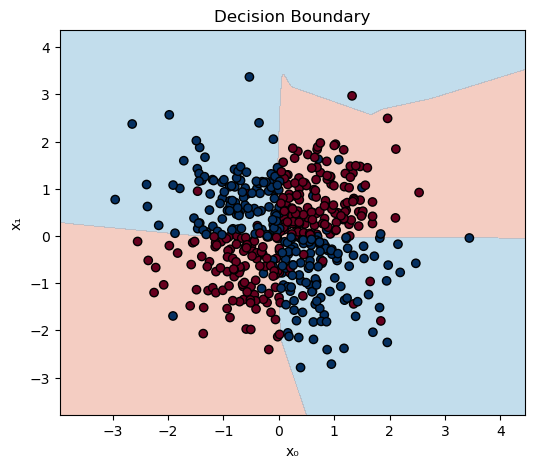

In [16]:
def plot_decision_boundary(model, X, y, scaler=None, title="Decision Boundary"):
    # Prepare a mesh grid over input space
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    grid = np.c_[xx.ravel(), yy.ravel()]
    if scaler is not None:
        grid = scaler.transform(grid)

    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(grid, dtype=torch.float32)
        outputs = torch.sigmoid(model.model(inputs)).numpy()
    Z = outputs.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.4, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k')
    plt.title(title)
    plt.xlabel('x₀')
    plt.ylabel('x₁')
    plt.show()
    
    
plot_decision_boundary(model, X_test_s, y_test.to_numpy(), scaler=model_for_scaling.scaler, title="Decision Boundary")

The plot shows that the neural network successfully learned to separate the two classes with a smooth non-linear boundary.It correctly classifies most points, with a test accuracy of around 0.92. The regions correspond to the model’s confidence for each class.

3. Which optimizer did you choose? Discuss the differences between SGD and Adam.
I chose Adam, an adaptive learning rate optimization algorithm that combines the benefits of both AdaGrad and RMSProp. Adam computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. This allows it to perform well on a wide range of problems with minimal hyperparameter tuning. SGD stands for Stochastic Gradient Descent, which updates model parameters using the gradient of the loss function with respect to a random subset (mini-batch) of the training data. Adam generally converges faster and requires less tuning of the learning rate compared to SGD. Also, Adam is more adapted to tend to noisy gradients and sparse data.



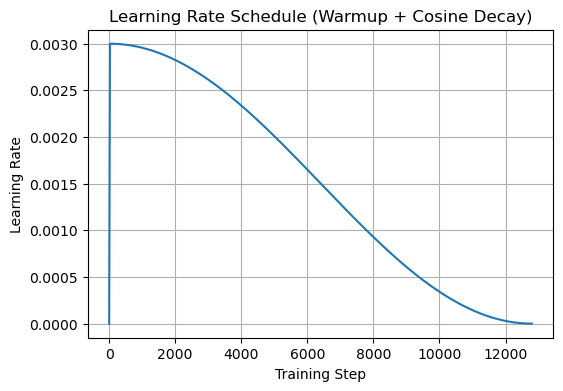

In [17]:
# 4. Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?

model.plot_learning_rate_schedule(n_epochs=400, base_lr=0.001, min_lr=1e-6, warmup_steps=100, train_loader=train_loader)

🧪 Ablation Study Results

🔬 Testing: Baseline (3-layer)
   Description: Original 3-layer network with warmup
Test Accuracy: 0.91
   ✅ Test Accuracy: 0.9080

🔬 Testing: Simple (1-layer)
   Description: Simple 1-layer network
   ✅ Test Accuracy: 0.9120

🔬 Testing: Deep (5-layer)
   Description: Deeper 5-layer network
   ✅ Test Accuracy: 0.9000

🔬 Testing: With Dropout
   Description: 3-layer network with dropout
   ✅ Test Accuracy: 0.8800

🔬 Testing: No Warmup
   Description: Original network without warmup
   ✅ Test Accuracy: 0.9200

🔬 Testing: Higher LR
   Description: Original network with higher learning rate
   ✅ Test Accuracy: 0.9220

📊 ABLATION STUDY SUMMARY
1. Higher LR: 0.9220 - Original network with higher learning rate
2. No Warmup: 0.9200 - Original network without warmup
3. Simple (1-layer): 0.9120 - Simple 1-layer network
4. Baseline (3-layer): 0.9080 - Original 3-layer network with warmup
5. Deep (5-layer): 0.9000 - Deeper 5-layer network
6. With Dropout: 0.8800 - 3-layer 

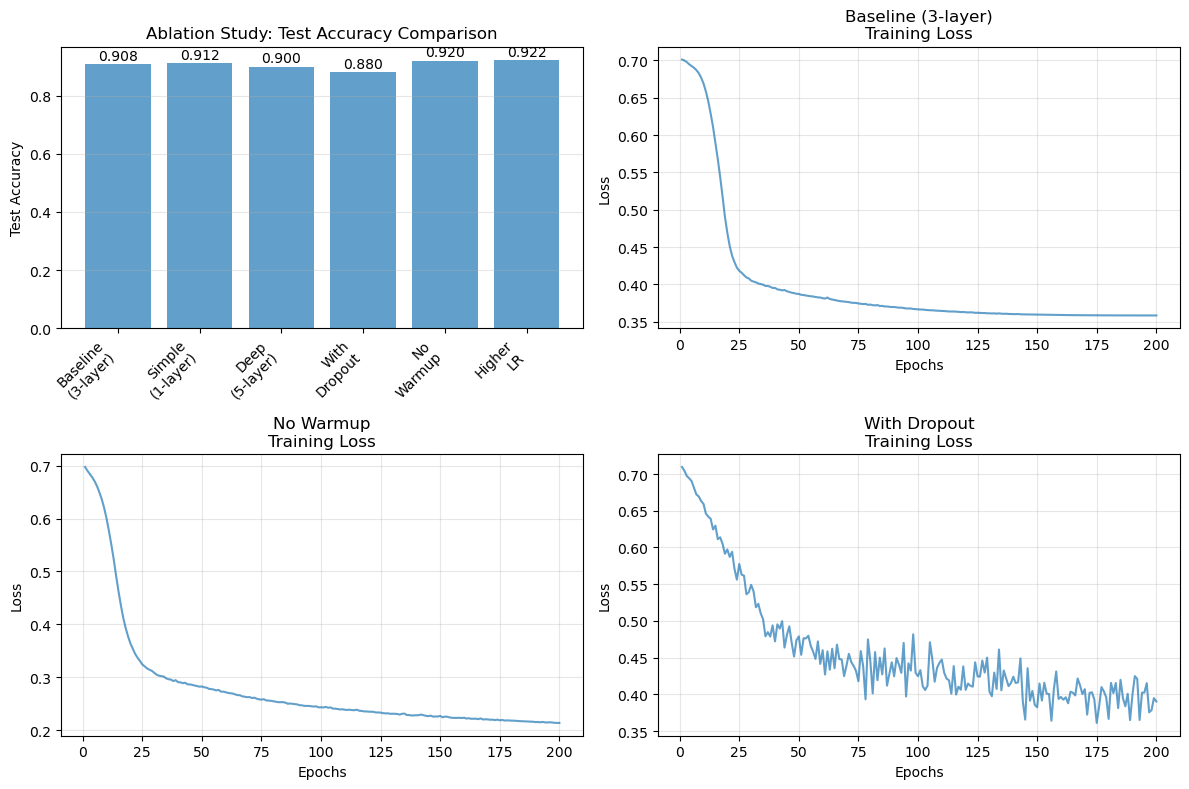

In [18]:
#5. Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.
# Ablation Study: Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

import torch.nn as nn

# First, let's create different model architectures for the ablation study
class SimpleNet(nn.Module):
    """Simple 1-layer network"""
    def __init__(self, input_size=2):
        super(SimpleNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.model(x)

class DeepNet(nn.Module):
    """Deeper 5-layer network"""
    def __init__(self, input_size=2):
        super(DeepNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.model(x)

class DropoutNet(nn.Module):
    """Network with dropout layers"""
    def __init__(self, input_size=2, dropout_rate=0.2):
        super(DropoutNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.model(x)

# Training function without warmup (constant learning rate)
def train_model_no_warmup(model, train_loader, test_loader, n_epochs=200, lr=0.001, device="cpu"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.to(device)
    train_losses, train_accs = [], []
    
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).long()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total if total > 0 else 0
        train_losses.append(train_loss)
        train_accs.append(train_acc)
    
    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            predicted = (torch.sigmoid(outputs) >= 0.5).long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = correct / total if total > 0 else 0
    return test_accuracy, train_losses, train_accs

# Ablation study configurations
ablation_configs = {
    "Baseline (3-layer)": {
        "model_class": NeuralNet,
        "use_warmup": True,
        "use_dropout": False,
        "lr": 0.001,
        "description": "Original 3-layer network with warmup"
    },
    "Simple (1-layer)": {
        "model_class": SimpleNet,
        "use_warmup": False,
        "use_dropout": False,
        "lr": 0.001,
        "description": "Simple 1-layer network"
    },
    "Deep (5-layer)": {
        "model_class": DeepNet,
        "use_warmup": False,
        "use_dropout": False,
        "lr": 0.001,
        "description": "Deeper 5-layer network"
    },
    "With Dropout": {
        "model_class": DropoutNet,
        "use_warmup": False,
        "use_dropout": True,
        "lr": 0.001,
        "description": "3-layer network with dropout"
    },
    "No Warmup": {
        "model_class": NeuralNet,
        "use_warmup": False,
        "use_dropout": False,
        "lr": 0.001,
        "description": "Original network without warmup"
    },
    "Higher LR": {
        "model_class": NeuralNet,
        "use_warmup": False,
        "use_dropout": False,
        "lr": 0.01,
        "description": "Original network with higher learning rate"
    }
}

print("🧪 Ablation Study Results")
print("=" * 50)

ablation_results = {}
train_loader_ablation = NeuralNet.make_loader(X_train_s, y_train.to_numpy(), batch_size=32, shuffle=True)

for config_name, config in ablation_configs.items():
    print(f"\n🔬 Testing: {config_name}")
    print(f"   Description: {config['description']}")
    
    # Create model
    if config["model_class"] == DropoutNet:
        model_test = config["model_class"](input_size=2, dropout_rate=0.2)
    else:
        model_test = config["model_class"](input_size=2)
    
    if config["use_warmup"] and hasattr(model_test, 'train_model'):
        # Use the NeuralNet class method with warmup
        trained_model, losses, accs = model_test.train_model(
            train_loader_ablation,
            n_epochs=200,
            base_lr=config["lr"],
            min_lr=1e-6,
            warmup_steps=50
        )
        test_accuracy = model_test.evaluate_model(test_loader)
    else:
        # Use simple training without warmup
        test_accuracy, losses, accs = train_model_no_warmup(
            model_test, 
            train_loader_ablation, 
            test_loader,
            n_epochs=200,
            lr=config["lr"]
        )
    
    ablation_results[config_name] = {
        'accuracy': test_accuracy,
        'losses': losses,
        'accs': accs,
        'description': config['description']
    }
    
    print(f"   ✅ Test Accuracy: {test_accuracy:.4f}")

print("\n" + "=" * 50)
print("📊 ABLATION STUDY SUMMARY")
print("=" * 50)

# Sort results by accuracy
sorted_results = sorted(ablation_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for i, (config_name, result) in enumerate(sorted_results):
    print(f"{i+1}. {config_name}: {result['accuracy']:.4f} - {result['description']}")

print("\n🔍 Key Insights:")
best_config = sorted_results[0]
worst_config = sorted_results[-1]
print(f"• Best configuration: {best_config[0]} ({best_config[1]['accuracy']:.4f})")
print(f"• Worst configuration: {worst_config[0]} ({worst_config[1]['accuracy']:.4f})")
print(f"• Performance difference: {best_config[1]['accuracy'] - worst_config[1]['accuracy']:.4f}")

# Find baseline for comparison
baseline_acc = ablation_results.get("Baseline (3-layer)", {}).get('accuracy', 0)
if baseline_acc > 0:
    print(f"\n📈 Compared to baseline ({baseline_acc:.4f}):")
    for config_name, result in ablation_results.items():
        if config_name != "Baseline (3-layer)":
            diff = result['accuracy'] - baseline_acc
            sign = "+" if diff >= 0 else ""
            print(f"  • {config_name}: {sign}{diff:.4f}")

# Plot comparison
plt.figure(figsize=(12, 8))

# Plot 1: Test Accuracies
plt.subplot(2, 2, 1)
configs = list(ablation_results.keys())
accuracies = [ablation_results[config]['accuracy'] for config in configs]
bars = plt.bar(range(len(configs)), accuracies, alpha=0.7)
plt.xticks(range(len(configs)), [config.replace(' ', '\n') for config in configs], rotation=45, ha='right')
plt.ylabel('Test Accuracy')
plt.title('Ablation Study: Test Accuracy Comparison')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 2-4: Training curves for selected configurations
selected_configs = ["Baseline (3-layer)", "No Warmup", "With Dropout"]
for i, config in enumerate(selected_configs[:3]):
    plt.subplot(2, 2, i+2)
    if config in ablation_results:
        epochs = range(1, len(ablation_results[config]['losses']) + 1)
        plt.plot(epochs, ablation_results[config]['losses'], label='Loss', alpha=0.7)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{config}\nTraining Loss')
        plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [28]:
# Hmmmmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)
data

,ID,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0,0.314365,0.646305,0.323849,0.238492,0.655790,0.646305,0.646305,0.409205,0.646305,...,0.646305,0.646305,0.655790,0.238492,0.646305,0.674758,0.646305,0.238492,0.655790,0.646305
1,1,0.587628,0.494976,0.559832,-0.246237,0.513506,0.550567,0.522772,0.596893,0.606158,...,0.587628,0.550567,0.587628,0.587628,0.550567,0.587628,0.550567,0.596893,0.494976,0.587628
2,2,0.590203,0.367673,0.367673,0.367673,0.367673,0.590203,0.367673,0.590203,0.590203,...,0.590203,0.367673,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.476556
3,3,0.589296,0.589296,0.579825,0.551415,0.579825,0.579825,0.608236,0.579825,0.646118,...,0.532474,0.523003,0.589296,0.589296,0.551415,0.134721,0.475652,0.589296,0.570355,0.551415
4,4,0.660095,0.470676,0.190366,0.672806,0.470761,0.672766,0.672652,0.666151,0.672987,...,0.432001,0.672222,0.190568,0.217329,0.633684,0.673294,0.587914,0.671023,0.207578,0.470765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.340739,0.340739,0.340739,0.681823,0.340739,0.340739,0.340739,0.672083,0.340739,...,0.340739,0.662355,0.340739,0.759779,0.331011,0.759779,0.340739,0.691563,0.340734,0.720789
3996,3996,0.384257,0.384257,0.675221,0.384257,0.384257,0.675221,0.384257,0.675221,0.675221,...,0.675221,0.384257,0.675221,0.675221,0.675221,0.384257,0.384257,0.384257,0.675221,0.675221
3997,3997,0.641837,0.651135,0.251329,0.251329,0.651135,0.651135,0.251329,0.651135,0.651135,...,0.251329,0.251329,0.651135,0.251329,0.409392,0.604646,0.651135,0.651135,0.660433,0.251329
3998,3998,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,-0.212897,0.555533,...,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533


In [29]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


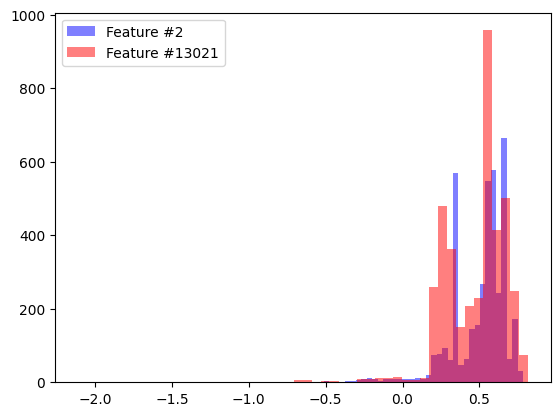

In [6]:
# Features seem to be similarly distributed...
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()
plt.show()

In [ ]:
# data_new = pd.read_csv('unsupervised_data.csv')

# # Extracting original column names and sorting them based on the numeric value after 'col_'
# original_columns = data_new.columns

There are 16385 - 1 = 16384 row which is a perfect square. 128x128 to be precise, seems a lot like that is a picture, and it is pixel values.Each row is a flattened 128×128 image

In [30]:
# sorted_columns = sorted(original_columns, key=lambda x: int(x.split('_')[1]))

# # Reorder the dataframe using the sorted columns
# data_sorted = data_new[sorted_columns]
# X = data_sorted.values

# print("X shape:", X.shape)  # (4000, 16384)

# image_data = X.reshape(-1, 128, 128)

# # Show first few images (you can change the starting index)
# start_index = 0   # e.g. skip first 10 images
# num_images = 5

# fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# for i in range(num_images):
#     if start_index + i < image_data.shape[0]:
#         axes[i].imshow(image_data[start_index + i], cmap='gray')
#         axes[i].axis('off')
#         axes[i].set_title(f"Image #{start_index + i}")
# plt.tight_layout()
# plt.show()

scaler = StandardScaler()

X = data.values
X_scaled = scaler.fit_transform(X)

We can try to reduce the dimensions of the data to then cluster data and try to extract some meaning out of it. I will try to use the techniques we have learnt in class such as PCA, and T-SNE.

Explained variance ratio (first 50): 0.2310571254439903


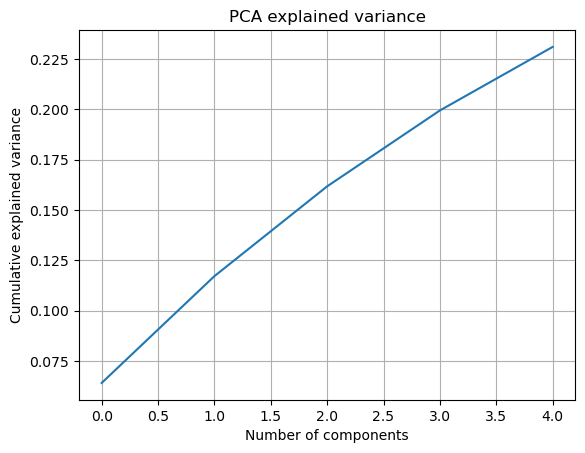

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# reduce dimensions to 50
pca = PCA(n_components=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Explained variance is the proportion of the dataset's variance that lies along each principal component.
print("Explained variance ratio (first 50):", pca.explained_variance_ratio_.sum())

# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance")
plt.grid(True)
plt.show()


In [ ]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)




In [7]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,cluster
0,0,2
1,1,6
2,2,3
3,3,3
4,4,8
...,...,...
3995,3995,3
3996,3996,7
3997,3997,3
3998,3998,7



---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [8]:
import numpy as np
import scipy.optimize
import sklearn.metrics

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [9]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(1.0)

In [10]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.3333333333333333)

In [11]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.5)